## 修改與簡化

- 為降低不確定性，取消價格機制
- 買賣家決定原本取決於價格
- 修改為人造隨機生成之小國網路

In [1]:
from functools import partial
import networkx as nx
from itertools import count
import numpy as np
from src.network_creation import (
    edge_distribution_to_bipartite_network,
    generate_degree_from_prob_list,
    get_probability_array_for_agents,
    generate_cross_broader_bipartite)

from matplotlib import pyplot as plt

## Network creation

In [2]:
node_n = 30
avg_edge = 5
total_edge = node_n * avg_edge

distribution_function = partial(np.random.exponential, scale=1)
edges = []
population = [1,1,0.5, 0.5]
for i in range(4):
    total_trading_volume = int( total_edge * population[i])
    probability_array = get_probability_array_for_agents( int( node_n * population[i]), distribution_function)
    edges.append(
        generate_degree_from_prob_list( total_trading_volume, probability_array)
    )

id_generator = count()
node_1, G1 = edge_distribution_to_bipartite_network(edges[0], edges[1], ("buyer", "seller"), id_generator, country = "home")
node_2, G2 = edge_distribution_to_bipartite_network(edges[2], edges[3], ("buyer", "seller"), id_generator, country = "foreign")
node_refs, combined = generate_cross_broader_bipartite(G1, G2, international_level=0.8)


See web demo

## Model

In [3]:
from src.schedule import ThesisScheduler
from src.model import ThesisModel

In [4]:
custom_scheduler = ThesisScheduler
model = ThesisModel(N=30, cross_border_payment_network=combined)
for i in range(50):
    model.step()

Deciding consumptions for buyer 15
Deciding consumptions for buyer 70
Deciding consumptions for buyer 22
Deciding consumptions for buyer 8
Deciding consumptions for buyer 68
Deciding consumptions for buyer 72
Deciding consumptions for buyer 67
Deciding consumptions for buyer 65
Deciding consumptions for buyer 64
Deciding consumptions for buyer 17
Deciding consumptions for buyer 3
Deciding consumptions for buyer 2
Deciding consumptions for buyer 7
Deciding consumptions for buyer 63
Deciding consumptions for buyer 29
Deciding consumptions for buyer 26
Deciding consumptions for buyer 19
Deciding consumptions for buyer 11
Deciding consumptions for buyer 27
Deciding consumptions for buyer 24
Deciding consumptions for buyer 16
Deciding consumptions for buyer 20
Deciding consumptions for buyer 66
Deciding consumptions for buyer 21
Deciding consumptions for buyer 12
Deciding consumptions for buyer 23
Deciding consumptions for buyer 14
Deciding consumptions for buyer 62
Deciding consumptions fo

In [5]:
model.agents[20]._MOP

{MeansOfPaymentType(name='H_Cash', exchange_rate_to_real=1): -15.0,
 MeansOfPaymentType(name='H_Deposit', exchange_rate_to_real=1): -15.0}

In [6]:
observed_mop_for_home = {aid: a.MOP_observe_freq for aid, a in model.schedule._sellers.items() if a.country == 'home'}
observed_mop_for_home

{30: {MeansOfPaymentType(name='H_Cash', exchange_rate_to_real=1): 0.49324324324324326,
  MeansOfPaymentType(name='H_Deposit', exchange_rate_to_real=1): 0.49324324324324326,
  MeansOfPaymentType(name='F_Deposit', exchange_rate_to_real=1): 0.006756756756756757,
  MeansOfPaymentType(name='F_Cash', exchange_rate_to_real=1): 0.006756756756756757},
 31: {MeansOfPaymentType(name='H_Cash', exchange_rate_to_real=1): 0.4927536231884058,
  MeansOfPaymentType(name='H_Deposit', exchange_rate_to_real=1): 0.4927536231884058,
  MeansOfPaymentType(name='F_Deposit', exchange_rate_to_real=1): 0.007246376811594203,
  MeansOfPaymentType(name='F_Cash', exchange_rate_to_real=1): 0.007246376811594203},
 32: {MeansOfPaymentType(name='H_Cash', exchange_rate_to_real=1): 0.4963768115942029,
  MeansOfPaymentType(name='H_Deposit', exchange_rate_to_real=1): 0.4963768115942029,
  MeansOfPaymentType(name='F_Deposit', exchange_rate_to_real=1): 0.0036231884057971015,
  MeansOfPaymentType(name='F_Cash', exchange_rate_to_

In [7]:
from src.payment import MeansOfPaymentType

f_mop = [mop for mop in model.init_mops.values() if mop.name.startswith('F')]

In [8]:
mop_stat = {
    f_mop[0]: [],
    f_mop[1]: []
}

for agent_data in observed_mop_for_home.values():
    for mop, v in agent_data.items():
        if mop in f_mop:
            mop_stat[mop].append(v)


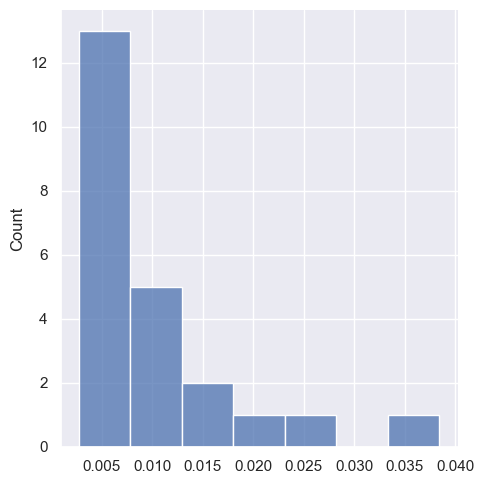

In [9]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.displot(mop_stat[f_mop[0]])

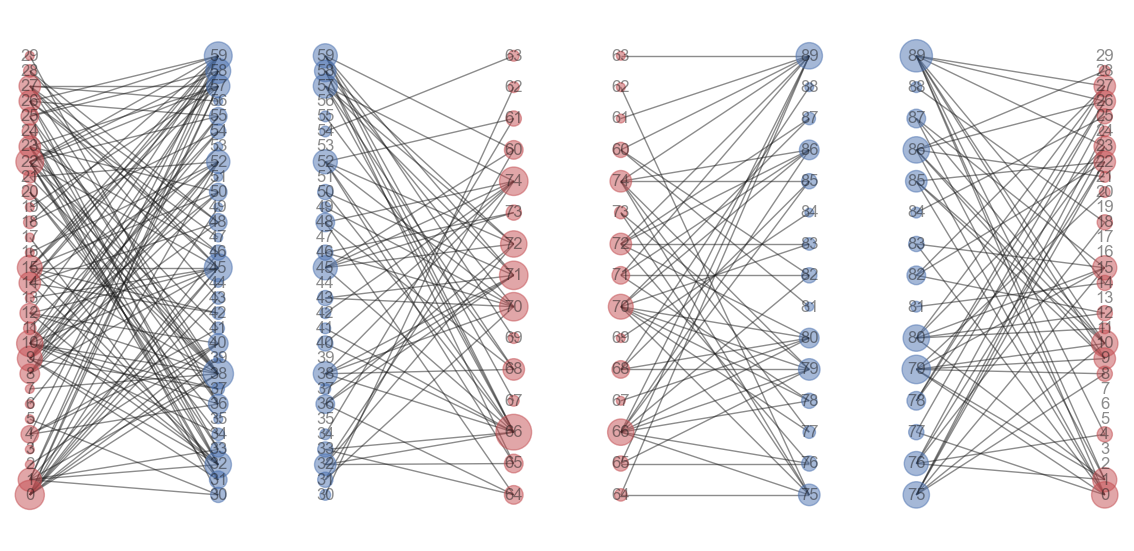

In [10]:

with_label_param = True

fig, axs = plt.subplots(1,4, figsize=(12,6))
fig.tight_layout()
pos1 = nx.bipartite_layout(G1, set(node_1), scale = 2)
pos2 = nx.bipartite_layout(G2, set(node_2), scale = 2)
nx.draw(
    G1,
    ax = axs[0],
    pos = pos1,
    node_color = ['r'] * node_n + ['b'] * node_n,
    alpha = 0.5,
    node_size =[ deg * 40 for deg in dict(G1.degree).values()],
    with_labels = with_label_param,
)

nx.draw(
    G2,
    ax = axs[2],
    pos = pos2,
    node_color = ['r'] * len(node_2) + ['b'] * len(node_2),
    alpha = 0.5,
    node_size =[ deg * 40 for deg in dict(G2.degree).values()],
    with_labels = with_label_param,
)


buyer1_and_seller_2 = (set(node_refs[0]) | set(node_refs[3]))
buyer2_and_seller_1 = (set(node_refs[1]) | set(node_refs[2]))
view_two_country_1 = nx.subgraph_view(combined, filter_node= lambda n: n in buyer1_and_seller_2)
view_two_country_2 = nx.subgraph_view(combined, filter_node= lambda n: n in buyer2_and_seller_1)

pos_b1s2 = nx.bipartite_layout(view_two_country_1, node_refs[3], scale = 2)
pos_b2s1 = nx.bipartite_layout(view_two_country_2, node_refs[1], scale = 2)
colors_1 = ['r'] * len(node_refs[0]) + ['b'] * len(node_refs[3])
colors_2 = ['b'] * len(node_refs[0]) + ['r'] * len(node_refs[3])
nx.draw(
    view_two_country_1,
    ax = axs[3],
    pos=pos_b1s2,
    node_color = colors_1,
    alpha = 0.5,
    node_size =[ deg * 60 for deg in dict(view_two_country_1.degree).values()],
    with_labels = with_label_param)

nx.draw(
    view_two_country_2,
    ax = axs[1],
    pos=pos_b2s1,
    node_color = colors_2,
    alpha = 0.5,
    node_size =[ deg * 60 for deg in dict(view_two_country_2.degree).values()],
    with_labels = with_label_param,
)


In [ ]:
observed_mop_for_home[50]

{MeansOfPaymentType(name='H_Cash', exchange_rate_to_real=1): 0.4971590909090909,
 MeansOfPaymentType(name='H_Deposit', exchange_rate_to_real=1): 0.4971590909090909,
 MeansOfPaymentType(name='F_Deposit', exchange_rate_to_real=1): 0.002840909090909091,
 MeansOfPaymentType(name='F_Cash', exchange_rate_to_real=1): 0.002840909090909091}

In [ ]:
observed_mop_for_home[42]

{MeansOfPaymentType(name='H_Cash', exchange_rate_to_real=1): 0.4875,
 MeansOfPaymentType(name='H_Deposit', exchange_rate_to_real=1): 0.4875,
 MeansOfPaymentType(name='F_Deposit', exchange_rate_to_real=1): 0.0125,
 MeansOfPaymentType(name='F_Cash', exchange_rate_to_real=1): 0.0125}

In [ ]:
model.schedule._buyers[61].MOP_observe_freq

{MeansOfPaymentType(name='F_Cash', exchange_rate_to_real=1): 0.49038461538461536,
 MeansOfPaymentType(name='F_Deposit', exchange_rate_to_real=1): 0.49038461538461536,
 MeansOfPaymentType(name='H_Cash', exchange_rate_to_real=1): 0.009615384615384616,
 MeansOfPaymentType(name='H_Deposit', exchange_rate_to_real=1): 0.009615384615384616}

In [11]:
model.home_bank.liability

{30: 34.0,
 31: 30.0,
 32: 57.0,
 33: 25.0,
 34: 22.0,
 35: 19.0,
 36: 33.0,
 37: 16.0,
 38: 76.0,
 39: 13.0,
 40: 38.0,
 41: 30.0,
 42: 23.0,
 43: 13.0,
 44: 14.0,
 45: 64.0,
 46: 13.0,
 47: 11.0,
 48: 32.0,
 49: 12.0,
 50: 29.0,
 51: 16.0,
 52: 56.0,
 53: 13.0,
 54: 39.0,
 55: 26.0,
 56: 13.0,
 57: 39.0,
 58: 51.0,
 59: 66.0,
 0: -15.0,
 1: -16.0,
 2: -3.0,
 3: -3.0,
 4: -15.0,
 5: -3.0,
 6: -2.0,
 7: -1.0,
 8: -15.0,
 9: -14.0,
 10: -15.0,
 11: -15.0,
 12: -15.0,
 13: -3.0,
 14: -15.0,
 15: -15.0,
 16: -3.0,
 17: -3.0,
 18: -15.0,
 19: -2.0,
 20: -15.0,
 21: -15.0,
 22: -14.0,
 23: -15.0,
 24: -14.0,
 25: -14.0,
 26: -16.0,
 27: -15.0,
 28: -15.0,
 29: -2.0}